## Table of Contents
- [Global Import](#global-import)
    - [Main Functions](#main-functions)
- [Data Preprocessing](#data-preprocessing)    
    - [Unpacking](#unpacking)
        - [`"proj_xz.pkl"`](#proj_xz-pkl)
        - [`"input.dat"`](#input-dat)
    - [Creating Input Dataset](#creating-input-dataset)
        - [Spike Times](#spike-times)
        - [Batches](#batches)
        - [`stim_train`](#stim-train)
            - [Batches vs `stim_train`](#batches-vs-stim)
        - [GID to `xz_array` Index & Creating `x_data`](#creating-x-data)
- [Autoencoder](#autoencoder)
    - [Building](#building)
    - [Initial Training & Analysis](#initial-training-and-analysis)
- [Analysis](#analysis)
    - [Analytical Tools Development](#analytical-tools-development)
        - [Comparative Histogram](#comparative-histogram)
        - [Comparative Animation](#comparative-animation)
        - [Working with Patterns](#working-with-patterns)
            - [Pattern Sums](#pattern-sums)
            - [Pattern Distributions](#pattern-sums)
            - [Summary Table](#summary-table)
- [TODO](#todo)
- [Project Log](#project-log)

# Global Import <a class="anchor" id="global-import"></a>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors

import numpy as np
np.set_printoptions(suppress=True)

import pickle as pkl

from keras.models import load_model

Using TensorFlow backend.


## Main Functions <a class="anchor" id="main-functions"></a>

In [2]:
with open('data/input/xz_array.pkl', 'rb') as f:
    xz_array = pkl.load(f)

In [25]:
def plot(data, titles=None, plot_title="title", show=False, save=True):
    if titles == None:
        titles = [""]*len(data)
        
    """Plots valued scatter plots."""
    fig, axs = plt.subplots(1, len(data), sharey=True, figsize=(4*len(data), 4))
    if len(data) == 1:
        axs = [axs]
        
    norm = colors.Normalize(vmin=0, vmax=1)
    cmap = plt.cm.get_cmap('plasma')
    rgba = cmap(0)

    for ax, title in zip(axs, titles):
        ax.set_title(title)
        ax.set(adjustable='box-forced', aspect='equal')
        ax.set_facecolor(rgba)      
    
    images = [axs[i].scatter(xz_array[:, 1], xz_array[:, 2], c=np.zeros(xz_array.shape[0]), s=3, cmap='plasma') \
              for i in range(len(axs))]
    
    fig.colorbar(images[0], ax=list(axs), orientation='vertical', fraction=.02)

    if len(data[0].shape) == 1:
        for i, im in enumerate(images):
            im.set_norm(norm)
            im.set_array(data[i].reshape(-1))
        
        if save == True:
            fig.savefig('data/incite/{}'.format(plot_title), dpi=300)
    else:
        def update(frame):
            for i, im in enumerate(images):
                im.set_norm(norm)
                im.set_array(data[i][frame])
            return images

        ani = animation.FuncAnimation(fig, update, frames=data[0].shape[0],\
                                      interval=500, blit=True)
        if save == True:
            ani.save("data/incite/{}.mp4".format(plot_title), dpi=300)
        
    if show == True:
        plt.show()

# Data Preprocessing <a class="anchor" id="data-preprocessing"></a>

> Please find attached an exemplar input file for the simulations we are running.

> I also attached a dictionary with the X and Z coordinate of each innervating fiber.

> Stimuli are presented every 200 ms.

## Unpacking <a class="anchor" id="unpacking"></a>
### `"proj_xz.pkl"` <a class="anchor" id="proj_xz-pkl"></a>

In [4]:
with open('data/input/proj_xz.pkl', 'rb') as f:
    xz_glob = pkl.load(f, encoding='latin1')

In [5]:
xz_array = np.zeros((1, 2))
keys = []
for key in xz_glob:
    keys.append(key)
    xz_array = np.concatenate((xz_array, xz_glob[key].reshape((1, 2))), axis=0)
keys = np.array(keys).reshape(-1, 1)
xz_array = np.concatenate((keys, xz_array[1:]), axis=1)

In [6]:
xz_array

array([[ 221184.   ,     489.488,     591.93 ],
       [ 221185.   ,     206.701,     563.71 ],
       [ 221186.   ,     319.906,     457.568],
       ..., 
       [ 221181.   ,     250.45 ,     495.846],
       [ 221182.   ,     479.566,     650.127],
       [ 221183.   ,     391.449,     464.526]])

In [7]:
with open('data/input/xz_array.pkl', 'wb') as f:
    pkl.dump(xz_array, f)

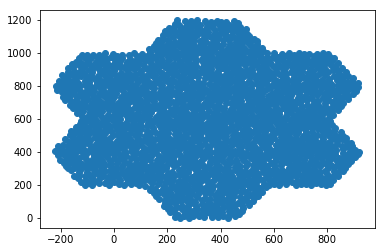

In [8]:
plt.scatter(xz_array[:, 1], xz_array[:, 2]) # background hexagonal structure
plt.show()

### `"input.dat"` <a class="anchor" id="input-dat"></a>
- `"input.dat"` contains spiking times paired with GIDs (global IDs)
- Patterns go in 200 ms packs
- To make pictures, add up activities over each 200 ms

In [9]:
input_ = np.loadtxt('data/input/input.dat', skiprows=1)
input_ = np.flip(input_, axis=1)

In [10]:
print(input_)
print(input_.shape)

[[ 221184.          1200.406006]
 [ 221184.          1801.768311]
 [ 221184.          1864.717529]
 ..., 
 [ 221183.         26553.761719]
 [ 221183.         27957.466797]
 [ 221183.         29371.466797]]
(77654, 2)


In [11]:
print("Avg fibres per spike time: {}".format(input_.shape[0] / np.unique(input_[:, 1]).shape[0]))

Avg fibres per spike time: 21.685004188774087


## Creating Input Dataset <a class="anchor" id="creating-input-dataset"></a>

### Spike Times <a class="anchor" id="spike-times"></a>

In [12]:
# Take all GIDs for each unique spike time.
times = np.unique(input_[:, 1])
times_ids = [input_[:, 0][np.argwhere(input_ == i)[:, 0]] for i in times]

In [13]:
times_ids[0]

array([ 220747.,  220750.,  220756.,  220762.,  220765.,  220773.,
        220774.,  220778.,  220781.,  220786.,  220788.,  220796.,
        220801.,  220806.,  220808.,  220809.,  220821.,  220826.,
        220828.,  220837.,  220849.,  220862.,  220873.,  220898.])

In [14]:
# Translate GIDs into coordinates for each spike time.
times_xz = []
for ids in times_ids:
    a = [xz_array[np.argwhere(xz_array == id_)[:, 0], :] for id_ in ids]
    times_xz.append(np.concatenate(a))

In [15]:
# `times_xz` - list of GIDs for each spike time (with coordinates), list of 2darrays.
print(len(times_xz))
print(times_xz[0].shape)
print(times_xz[0][:10])

3581
(24, 3)
[[ 220747.        -37.143     429.791]
 [ 220750.        -47.967     414.168]
 [ 220756.        -35.846     447.929]
 [ 220762.        -54.281     438.775]
 [ 220765.        -66.346     412.825]
 [ 220773.        -71.532     430.597]
 [ 220774.        -45.261     463.382]
 [ 220778.        -83.033     397.495]
 [ 220781.        -68.714     451.273]
 [ 220786.        -33.083     481.641]]


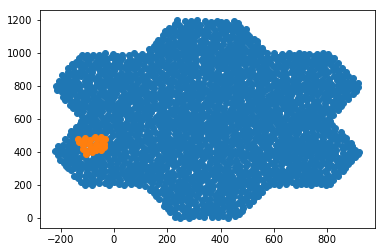

In [16]:
plt.scatter(xz_array[:, 1], xz_array[:, 2]) # background hexagonal structure
plt.scatter(times_xz[0][:, 1], times_xz[0][:, 2]) # single spike time pattern
plt.show()

### Batches <a class="anchor" id="batches"></a>

In [17]:
# Bin spike times into 200 ms intervals.
def batch(times, ms):
    batches_num = []
    batch_num = 0
    i_start = 0
    for i, time in enumerate(times):
        num = int(time // ms)
        if num > batch_num:
            batch_num = num
            batches_num.append(slice(i_start, i))
            i_start = i
        if i == len(times)-1:
            batches_num.append(slice(i_start, i+1))
    # Skip first second of random spiking.
    batches_num = batches_num[5:]
    return batches_num

In [18]:
batches_200 = batch(times, 200)

In [19]:
# `batches_200` - slices of indices for `times_xz` (200 ms batch times).
print(len(batches_200))
for i, batch in enumerate(batches_200):
    if i > 9:
        break
    else:
        print(batch)

145
slice(48, 74, None)
slice(74, 99, None)
slice(99, 121, None)
slice(121, 141, None)
slice(141, 169, None)
slice(169, 189, None)
slice(189, 217, None)
slice(217, 240, None)
slice(240, 263, None)
slice(263, 287, None)


In [20]:
# Make an animation representing all relevant 200 ms batches.
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(xz_array[:, 1], xz_array[:, 2])
ln, = ax.plot([], [], 'o', alpha=0.5, animated=True)

ax.set(adjustable='box-forced', aspect='equal')

def update(frame):
    xz = np.vstack(times_xz[batches_200[frame]])
    ln.set_data(xz[:, 1], xz[:, 2])
    return ln,

ani = animation.FuncAnimation(fig, update, frames=len(batches_200),\
                              interval=500, blit=True)
ani.save("data/incite/batches_200.mp4", dpi=300)

### `stim_train` <a class="anchor" id="stim-train"></a>

In [21]:
stim_train = [249980, 397555, 446691, 205315, 397555, 249980, \
              757795, 397555, 740558, 249980, 397555, 249980, \
              766947, 740558, 446691, 766947, 205315, 205315, \
              766947, 515018, 740558, 740558, 249980, 515018, \
              757795, 740558, 515018, 397555, 740558, 249980, \
              446691, 397555, 757795, 766947, 757795, 397555, \
              766947, 740558, 446691, 766947, 205315, 740558, \
              757795, 515018, 397555, 397555, 249980, 515018, \
              205315, 446691, 205315, 205315, 446691, 740558, \
              446691, 205315, 249980, 515018, 766947, 446691, \
              757795, 397555, 757795, 397555, 757795, 515018, \
              740558, 757795, 446691, 397555, 249980, 446691, \
              515018, 515018, 446691, 515018, 766947, 249980, \
              515018, 757795, 766947, 205315, 740558, 515018, \
              205315, 740558, 205315, 766947, 740558, 249980, \
              205315, 205315, 515018, 740558, 515018, 446691, \
              397555, 757795, 766947, 515018, 397555, 205315, \
              397555, 397555, 205315, 249980, 740558, 397555, \
              757795, 249980, 757795, 766947, 446691, 757795, \
              766947, 766947, 446691, 446691, 757795, 515018, \
              446691, 446691, 766947, 740558, 740558, 766947, \
              515018, 249980, 757795, 446691, 249980, 766947, \
              205315, 446691, 249980, 766947, 757795, 249980, \
              249980, 397555, 515018, 757795, 249980, 397555, 205315]

In [22]:
stim_train = np.array(stim_train)

In [23]:
with open('data/input/stim_train.pkl', 'wb') as f:
    pkl.dump(stim_train, f)

In [24]:
np.unique(stim_train)

array([205315, 249980, 397555, 446691, 515018, 740558, 757795, 766947])

In [25]:
len(stim_train)

145

#### Batches vs `stim_train`  <a class="anchor" id="batches-vs-stim"></a>
Check whether the 200 ms batches correctly represent `stim_train`.

In [26]:
# Contains GIDs for each 200 ms batch.
times_batched = [np.sort(np.vstack(times_xz[batch])[:, 0]) for batch in batches_200]

In [27]:
len(times_batched)

145

In [28]:
# Hash to check unique batches.
times_batched_hashed = [hash(batch.tostring()) for batch in times_batched]

In [29]:
np.unique(times_batched_hashed).shape

(145,)

This means that every batch has a unique set of fibres, which is how it should be.

**NB** This ↓ is equivalent to [**pattern sums**](#pattern-sums).

[  3  16  17  40  48  50  51  55  81  84  86  90  91 101 104 132 144]


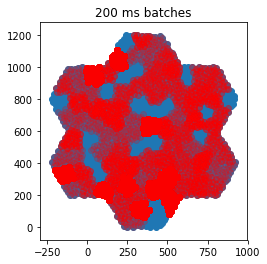

In [31]:
# Pick all indices from `stim_train` with the same specific value (representing the same pattern).
# 200 ms batches
pick = np.argwhere(stim_train == 205315).reshape(-1)
print(pick)

fig, ax = plt.subplots(figsize=(4, 4))

ax.set_title('200 ms batches')
ax.set(adjustable='box-forced', aspect='equal')
ax.scatter(xz_array[:, 1], xz_array[:, 2]) # background hexagonal structure
for i in pick:
    xz = np.vstack(times_xz[batches_200[i]])
    ax.scatter(xz[:, 1], xz[:, 2], c='r', alpha=0.2)
plt.show()

Plot all the input frames representing the same pattern (`pick` from previous cell).

In [32]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(xz_array[:, 1], xz_array[:, 2])
ln, = ax.plot([], [], 'ro', alpha=0.5, animated=True)

ax.set(adjustable='box-forced', aspect='equal')

def update(frame):
    xz = np.vstack(times_xz[batches_200[pick[frame]]])
    ln.set_data(xz[:, 1], xz[:, 2])
    return ln,

ani = animation.FuncAnimation(fig, update, frames=len(pick),\
                              interval=500, blit=True)
ani.save("data/incite/205315.mp4", dpi=300)

### GID to `xz_array` Index & Creating `x_data` <a class="anchor" id="creating-x-data"></a>

In [33]:
# GID --> index in `xz_array`.
GID_to_num = {val: ind for ind, val in enumerate(xz_array[:, 0])}

In [34]:
x_data = []
for batch in batches_200:
    batch_gids = np.vstack(times_xz[batch])[:, 0]
    batch_gid_nums = [GID_to_num[key] for key in batch_gids]
    data = np.bincount(batch_gid_nums)
    data = np.concatenate((data, np.zeros(len(GID_to_num.keys()) - len(data))))
    x_data.append(data)
x_data = np.array(x_data)

In [35]:
x_data.shape

(145, 2170)

In [36]:
np.max(x_data)

4.0

In [37]:
x_data = x_data / np.max(x_data) # Normalization

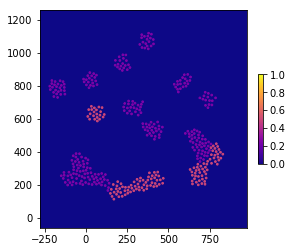

In [78]:
plot([x_data[0]], show=True, save=False)

In [39]:
# `x_data` - input to autoencoder.
# Normalized spike counts for each 200 ms bin.
print(x_data.shape)
print(x_data[:10, :10])
print(np.max(x_data))

(145, 2170)
[[ 0.    0.    0.    0.25  0.    0.    0.    0.25  0.    0.  ]
 [ 0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.25]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.5   0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.5   0.25  0.    0.    0.    0.    0.    0.    0.    0.5 ]
 [ 0.    0.    0.    0.5   0.    0.    0.    0.75  0.    0.  ]
 [ 0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.25]
 [ 0.5   0.    0.    0.    0.    0.    0.    0.    0.    0.5 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.25  0.25  0.    0.    0.5   0.    0.  ]]
1.0


In [40]:
# Divide into train and test sets.
div_ind = int(len(x_data)*0.8)
print(div_ind)
x_train = x_data[:div_ind]
x_test = x_data[div_ind:]

116


In [41]:
x_train.shape, x_test.shape

((116, 2170), (29, 2170))

In [42]:
with open('data/incite/x_train.pkl', 'wb') as f:
    pkl.dump(x_train, f)
with open('data/incite/x_test.pkl', 'wb') as f:
    pkl.dump(x_test, f)

# Autoencoder <a class="anchor" id="autoencoder"></a>
## Building <a class="anchor" id="building"></a>

In [43]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

Using TensorFlow backend.


In [44]:
def build_autoenc(encoding_dim=8, input_shape=(2170,), sparsity=0):

    # this is the size of our encoded representations
    encoding_dim = encoding_dim

    # this is our input placeholder
    input_img = Input(shape=input_shape)
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu', \
                    activity_regularizer=regularizers.l1(sparsity))(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(input_shape[0], activation='sigmoid')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)

    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)

    # create a placeholder for an encoded (encoding_dim-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))

    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')  

    return autoencoder, encoder, decoder

## Inintial Training & Analysis <a class="anchor" id="initial-training-and-analysis"></a>

In [45]:
with open('data/incite/x_train.pkl', 'rb') as f:
    x_train = pkl.load(f)
with open('data/incite/x_test.pkl', 'rb') as f:
    x_test = pkl.load(f)

In [51]:
# `AppendedHistory` - a class I wrote for one of the miniprojects for ANNs course
#                     and modified for this project.
#                     It allows storing and plotting parametrised learning curves.
from AppendedHistory import AppendedHistory
# Reloads modules automatically when they are changed.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
history_shuffle_300eps = AppendedHistory(varname='Shuffle Before Epoch', keys=['loss'])

In [ ]:
for i in range(3):
    autoencoder, encoder, decoder = build_autoenc()
    history = autoencoder.fit(x_train, x_train, \
                              epochs=300, \
                              batch_size=1, \
                              shuffle=True, \
                              validation_data=(x_test, x_test), \
                              verbose=0)
    autoencoder.save('data/incite/models_log/shuffle/autoencoder_300eps_true_{}'.format(i))
    encoder.save('data/incite/models_log/shuffle/encoder_300eps_true_{}'.format(i))
    decoder.save('data/incite/models_log/shuffle/decoder_300eps_true_{}'.format(i))
    history_shuffle_300eps.append_hist(True, history)

In [ ]:
for i in range(3):
    autoencoder, encoder, decoder = build_autoenc()
    history = autoencoder.fit(x_train, x_train, \
                              epochs=300, \
                              batch_size=1, \
                              shuffle=False, \
                              validation_data=(x_test, x_test), \
                              verbose=0)
    autoencoder.save('data/incite/models_log/shuffle/autoencoder_300eps_false_{}'.format(i))
    encoder.save('data/incite/models_log/shuffle/encoder_300eps_false_{}'.format(i))
    decoder.save('data/incite/models_log/shuffle/decoder_300eps_false_{}'.format(i))
    history_shuffle_300eps.append_hist(False, history)

In [ ]:
history_shuffle_300eps.save('data/incite/models_log/shuffle/history_shuffle_300eps')

In [52]:
history_shuffle_300eps = AppendedHistory(fname='data/incite/models_log/shuffle/history_shuffle_300eps')

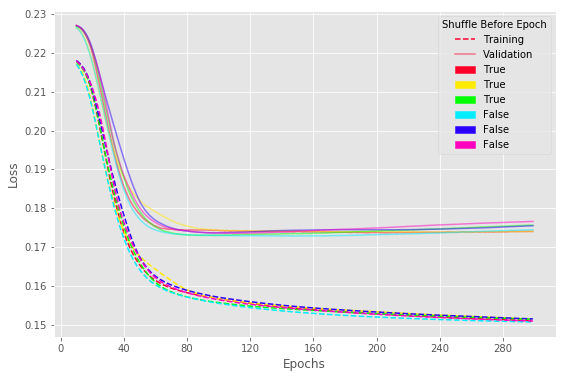

In [53]:
history_shuffle_300eps.plot("", "loss", False, [10, 300])

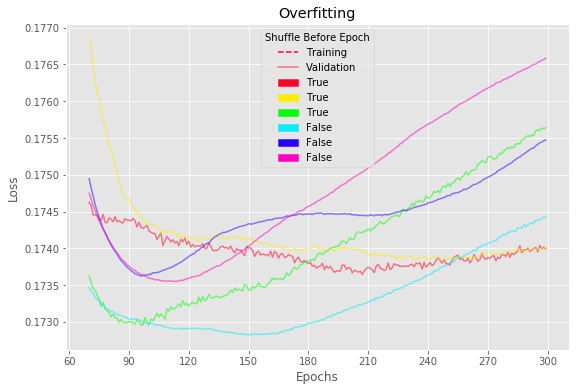

In [54]:
history_shuffle_300eps.plot("Overfitting", "val_loss", False, [70, 300], False)

There is no significant difference in learning for the two types os training (always original `x_train` vs shuffled before each epoch), except that the lines in the first case are smoother.

Given that the sequence shouldn't make difference since I present averaged (complete, 200 ms) patterns, I choose to stick with shuffled option.

In [ ]:
history_shuffle_true_100_200 = AppendedHistory(varname='Shuffle Before Epoch', keys=['loss'])

In [ ]:
for i in range(3):
    autoencoder, encoder, decoder = build_autoenc()
    history = autoencoder.fit(x_train, x_train, \
                              epochs=100, \
                              batch_size=1, \
                              shuffle=True, \
                              validation_data=(x_test, x_test), \
                              verbose=0)
    autoencoder.save('data/incite/models_log/shuffle/autoencoder_100eps_true_{}'.format(i))
    encoder.save('data/incite/models_log/shuffle/encoder_100eps_true_{}'.format(i))
    decoder.save('data/incite/models_log/shuffle/decoder_100eps_true_{}'.format(i))
    history_shuffle_true_100_200.append_hist('True_{}'.format(i), history)
    
    history = autoencoder.fit(x_train, x_train, \
                              epochs=100, \
                              batch_size=1, \
                              shuffle=True, \
                              validation_data=(x_test, x_test), \
                              verbose=0)
    autoencoder.save('data/incite/models_log/shuffle/autoencoder_200eps_true_{}'.format(i))
    encoder.save('data/incite/models_log/shuffle/encoder_200eps_true_{}'.format(i))
    decoder.save('data/incite/models_log/shuffle/decoder_200eps_true_{}'.format(i))
    history_shuffle_true_100_200.add_hist('True_{}'.format(i), history)

In [ ]:
history_shuffle_true_100_200.save('data/incite/models_log/shuffle/history_shuffle_true_100-200eps')

In [55]:
history_shuffle_true_100_200 = AppendedHistory(fname='data/incite/models_log/shuffle/history_shuffle_true_100-200eps')

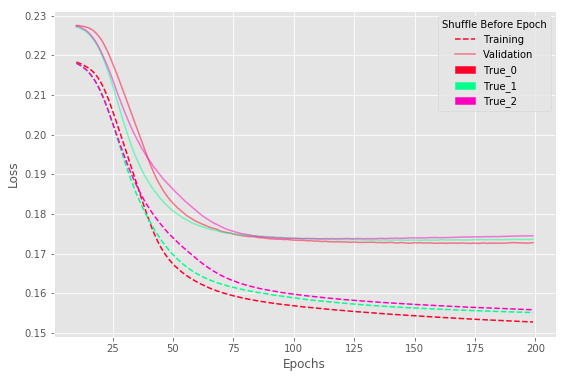

In [56]:
history_shuffle_true_100_200.plot("", "loss", False, [10, 200])

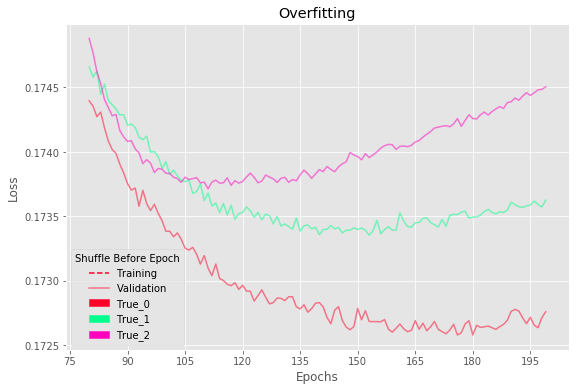

In [57]:
history_shuffle_true_100_200.plot("Overfitting", "val_loss", False, [80, 200], False)

Here, model corresponding to `True_0` in the best.

Let's take a closer look at it.

# Analysis <a class="anchor" id="analysis"></a>
## Analytical Tools Development <a class="anchor" id="analytical-tools-development"></a>
### Comparative Histogram <a class="anchor" id="comparative-histogram"></a>
`decoded` vs `x_test` distributions for each test vector.

In [4]:
with open('data/incite/x_train.pkl', 'rb') as f:
    x_train = pkl.load(f)
with open('data/incite/x_test.pkl', 'rb') as f:
    x_test = pkl.load(f)
x_data = np.vstack((x_train, x_test))

In [5]:
encoder = load_model('data/incite/models_log/shuffle/encoder_100eps_true_0')
decoder = load_model('data/incite/models_log/shuffle/decoder_100eps_true_0')

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_100 = encoder.predict(x_test)
decoded_100 = decoder.predict(encoded_100)

In [7]:
encoder = load_model('data/incite/models_log/shuffle/encoder_200eps_true_0')
decoder = load_model('data/incite/models_log/shuffle/decoder_200eps_true_0')

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
encoded_200 = encoder.predict(x_test)
decoded_200 = decoder.predict(encoded_200)

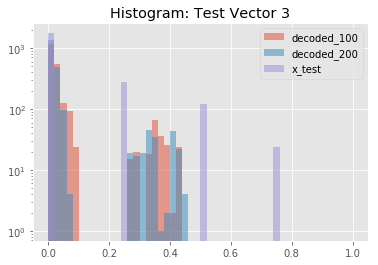

In [9]:
i = 3 # Insert i from 0 to 28.
with plt.style.context('ggplot'):
    plt.hist(decoded_100[i], log=True, bins=50, range=[0, 1], alpha=0.5, label='decoded_100')
    plt.hist(decoded_200[i], log=True, bins=50, range=[0, 1], alpha=0.5, label='decoded_200')
    plt.hist(x_test[i], log=True, bins=50, range=[0, 1], alpha=0.5, label='x_test')
    plt.title("Histogram: Test Vector {}".format(i))
    plt.legend()
plt.show()

As we see in the histogram, the values of the decoded images form 2 "groups", not 4 (like the input):
- close to 0,
- somewhere in between 0.2-0.6 (different for different patterns).

Seems like the autoencoder only differentiates between "most probably shouldn't be active" and "might be active".

Note that this kind of distribution is more or less what we should get due to the initial probabilistic approach.

In [10]:
print("decoded_100 - max value: {}".format(np.max(np.abs(decoded_100))))
print("decoded_200 - max value: {}".format(np.max(np.abs(decoded_200))))
print("max abs difference:      {}".format(np.max(np.abs(decoded_100 - decoded_200))))

decoded_100 - max value: 0.6333586573600769
decoded_200 - max value: 0.6711538434028625
max abs difference:      0.1351766288280487


### Comparative Animation <a class="anchor" id="comparative-animation"></a>

Visualization of `decoded` vs `x_test` by taking one test vector at a time.

In [11]:
plot([decoded_100, x_test], ['Decoded', 'Test'], 'comparison_100eps')

### Working with Patterns <a class="anchor" id="working-with-patterns"></a>

In [12]:
with open('data/input/stim_train.pkl', 'rb') as f:
    stim_train = pkl.load(f)

In [13]:
# `d_data` - dictionary of all indices of each pattern, dict.
d_data = {}
for i in np.unique(stim_train):
    d_data[i] = np.argwhere(stim_train == i).reshape(-1)

In [14]:
d_data

{205315: array([  3,  16,  17,  40,  48,  50,  51,  55,  81,  84,  86,  90,  91,
        101, 104, 132, 144]),
 249980: array([  0,   5,   9,  11,  22,  29,  46,  56,  70,  77,  89, 105, 109,
        127, 130, 134, 137, 138, 142]),
 397555: array([  1,   4,   7,  10,  27,  31,  35,  44,  45,  61,  63,  69,  96,
        100, 102, 103, 107, 139, 143]),
 446691: array([  2,  14,  30,  38,  49,  52,  54,  59,  68,  71,  74,  95, 112,
        116, 117, 120, 121, 129, 133]),
 515018: array([ 19,  23,  26,  43,  47,  57,  65,  72,  73,  75,  78,  83,  92,
         94,  99, 119, 126, 140]),
 740558: array([  8,  13,  20,  21,  25,  28,  37,  41,  53,  66,  82,  85,  88,
         93, 106, 123, 124]),
 757795: array([  6,  24,  32,  34,  42,  60,  62,  64,  67,  79,  97, 108, 110,
        113, 118, 128, 136, 141]),
 766947: array([ 12,  15,  18,  33,  36,  39,  58,  76,  80,  87,  98, 111, 114,
        115, 122, 125, 131, 135])}

In [15]:
d_train = {key: d_data[key][np.where(d_data[key] < 116)] for key in d_data.keys()}

In [16]:
d_test = {key: d_data[key][np.where(d_data[key] >= 116)]-116 for key in d_data.keys()}

#### Pattern Sums  <a class="anchor" id="pattern-sums"></a>

In [17]:
# `sums` - normalized sums of the activations of all instances of each pattern, list of 1darrays.
def get_sums(d_data, x_data):
    sums = []
    for key in d_data.keys():
        sum_ = x_data[d_data[key][0]]
        for i in d_data[key][1:]:
            sum_ = sum_ + x_data[i]
        sum_ = sum_ / np.max(sum_)
        sums.append(sum_)
    return sums

In [18]:
sums = get_sums(d_data, x_data)

In [26]:
for i, key in enumerate(d_data.keys()):
    plot([sums[i]], ['Pattern {}: Input Sum'.format(str(key))], 'pattern_sums_input/pattern_sum_{}.png'.format(key))

/Users/utanashati/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [20]:
sums_decoded = get_sums(d_test, decoded_100)

In [27]:
for i, key in enumerate(d_data.keys()):
    plot([sums_decoded[i]], ['Pattern {}: Decoded Sum'.format(str(key))], 'pattern_sums_decoded/pattern_sum_{}.png'.format(key))

/Users/utanashati/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


#### Patterns Distributions <a class="anchor" id="pattern-distributions"></a>

In [22]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [23]:
# `distribs` - distributions of encoded representations for each test pattern, list of 1darrays.
distribs = []
for key in d_test.keys():
    distrib = []
    for i in d_test[key]:
        distrib.append(encoded_imgs[i])
    distrib = np.array(distrib)
    distribs.append(distrib)

In [28]:
with plt.style.context('ggplot'):
    for i, key in enumerate(d_test.keys()):
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.set_ylim(0, 20)
        for distrib in distribs[i]:
            arr = np.vstack((np.arange(8)+1, distrib)).T
            ax.scatter(arr[:, 0], arr[:, 1], alpha=0.7)
        ax.set_title("Pattern {}: Decoded Distribution".format(key))
        fig.savefig("data/incite/pattern_distribs/pattern_distrib_{}.png".format(key), dpi=300)

/Users/utanashati/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


#### Summary Table <a class="anchor" id="summary-table"></a>

446691 | 757795 | 766947
--- | --- | ---
<img src="data/incite/pattern_sums_decoded/pattern_sum_446691.png" /> | <img src="data/incite/pattern_sums_decoded/pattern_sum_757795.png" /> | <img src="data/incite/pattern_sums_decoded/pattern_sum_766947.png" />
<img src="data/incite/pattern_sums_input/pattern_sum_446691.png" /> | <img src="data/incite/pattern_sums_input/pattern_sum_757795.png" /> | <img src="data/incite/pattern_sums_input/pattern_sum_766947.png" />
<img src="data/incite/pattern_distribs/pattern_distrib_446691.png" /> | <img src="data/incite/pattern_distribs/pattern_distrib_757795.png" /> | <img src="data/incite/pattern_distribs/pattern_distrib_766947.png" />

#### TODO <a class="anchor" id="todo"></a>
- Generate more data? (◎)
    - Get access to data generator? (◎)
- Compare representations (✓) and decoded images (✓) for the same patterns
- Insert examples of plots that are only saved, not shown (✓)
- Compare the results for different bottleneck sizes (◎)
- Compare representations of similar patterns (manifold learning) (◎)
- Look up t-SNE (◎)

#### Project Log <a class="anchor" id="project-log"></a>

**26.10.2018**
- Finished major clean up:
    - Got rid of irrelevant/old code/markdown
        - To make the contents tell a congruent story.
    - Notebook is no more structured by date, reasons being that:
        - I continue to improve what I've done before,
        - I clean up a lot of irrelevant info,
        - Transparent versioning (thx to GitHub) is still there.
- Created a new outline:
    - Each section and most revelant subsections can be loaded independently,
    - Table of contents:
        - Multilevel list,
        - Clickable.
- Modified `AppendedHistory` for the project
    - And used it throughout training (and will continue to use).
- Observed the effect of shuffling before each epoch on the learning process.
    - Visualized the best model.
        - [Comparative Histogram](#comparative-histogram) first done today.

**29.10.2018**
- Switched [Comparative Histogram](#comparative-histogram)'s scale to log.
- Tried solving an issue with markdown images on GitHub.